### Create AI - Image Semantic Segmentation Model

The project aims to enhance the accuracy of palm oil plantation segmentation by integrating the U-Net architecture with transfer learning from ResNet-34. U-Net’s symmetric structure and skip connections are adept at capturing spatial hierarchies, while ResNet-34’s pre-trained layers on vast datasets offer robust feature extraction capabilities. By combining these models, the project seeks to create a powerful semantic segmentation tool that can precisely delineate palm oil plantation areas from varied satellite imagery, contributing to more informed and sustainable agricultural practices. This approach not only promises improvements in segmentation precision but also expedites the training process, leveraging the strengths of both architectures for superior performance. 🌴🛰️

#### 1. Let's import the Dependencies

In [1]:
import random 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
 
import gc 
from tqdm.auto import tqdm 
from skimage.transform import resize 
from sklearn.model_selection import train_test_split 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import * 
from tensorflow.keras.optimizers import * 
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing.image import * 
from tensorflow.keras.callbacks import * 

from PIL import Image

seed = 2019 
random.seed = seed 
np.random.seed = seed 
tf.seed = seed

/home/vincent/skripsi_code/dl-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-22 16:54:11.518631: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 16:54:12.554800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 16:54:16.127377: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly

In [2]:
#Check Tensorflow Version
print(tf.__version__)


2.20.0


In [3]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Import the dataset and Checking the number of image and mask

In [2]:
import glob

# Collect images from both folders
train_x = sorted(glob.glob(r'/mnt/c/Users/vince/Skripsi/Data/Export_Training/256_192_with_non/images/*.png'))

# Collect labels from both folders
train_y = sorted(glob.glob(r'/mnt/c/Users/vince/Skripsi/Data/Export_Training/256_192_with_non/labels/*.png'))

# Optional: sort again if you need order alignment
train_x = sorted(train_x)
train_y = sorted(train_y)

print(len(train_x), len(train_y))

1721 1721


#### 2. Prepares image and mask data for deep learning tasks

The image will be converted into numpy array format

In [3]:
h, w = 256, 256

X = np.zeros((len(train_x), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_y), h, w, 1), dtype=np.float32)

In [4]:
for n, (img, mimg) in tqdm(enumerate(zip(train_x, train_y))):
  # Load images dengan target size 256x256
  img = load_img(img, target_size=(h, w))
  x_img = img_to_array(img)

  # Load mask grayscale dengan target size 256x256
  mask = load_img(mimg, color_mode="grayscale", target_size=(h, w))
  mask = img_to_array(mask)
  mask = (mask == 2).astype('float32')

  # Simpan hasil
  X[n] = x_img / 255.0
  y[n] = mask

1721it [01:13, 23.50it/s]


In [5]:
import gc; gc.collect()

0

In [6]:
print('uniq mask:', np.unique(y)[:5])  # harus {0., 1.}

uniq mask: [0. 1.]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(1548, 256, 256, 3) (1548, 256, 256, 1) (173, 256, 256, 3) (173, 256, 256, 1)


0

In [17]:
X_train

array([[[[0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         ...,
         [0.1294 , 0.1921 , 0.1137 ],
         [0.2118 , 0.2354 , 0.1372 ],
         [0.2274 , 0.2393 , 0.1608 ]],

        [[0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         ...,
         [0.1255 , 0.1765 , 0.102  ],
         [0.1647 , 0.2313 , 0.1451 ],
         [0.1843 , 0.2118 , 0.1333 ]],

        [[0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         ...,
         [0.2471 , 0.2666 , 0.1726 ],
         [0.251  , 0.2783 , 0.1686 ],
         [0.2354 , 0.302  , 0.1726 ]],

        ...,

        [[0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     ],
         ...,
         [0.0902 , 0.1765 , 0.0941 ],
         [0.0706 , 0.1372 , 0.0706 ],
         [0.0745 , 0.1372 , 0.08234]],

        [[

#### 4. Visualize Image and Mask

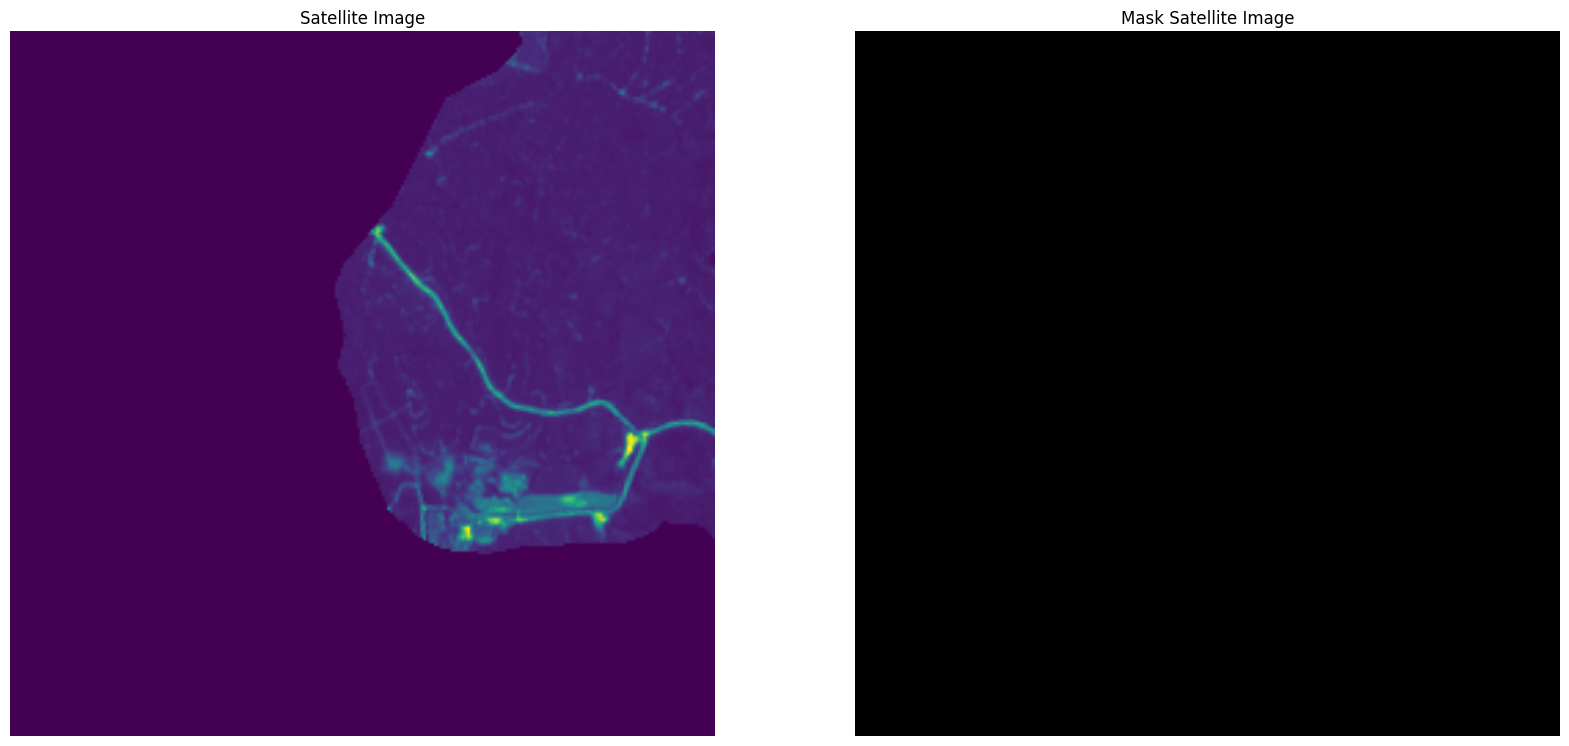

In [8]:
# Visualize any randome image along with the mask
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellite Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellite Image')
ax2.set_axis_off()

## 7. Transfer Learning Unet-Resnet34

U-Net with transfer learning using ResNet-34 is a powerful combination for image segmentation tasks. The U-Net architecture, known for its effectiveness in biomedical image segmentation, features a symmetric encoder-decoder structure with skip connections that help preserve spatial information. When combined with ResNet-34, which is pre-trained on large datasets like ImageNet, the model benefits from deep residual learning, allowing it to learn robust feature representations. This transfer learning approach helps in overcoming the challenge of training deep networks from scratch, especially when labeled data is scarce. By utilizing ResNet-34’s learned features, the U-Net model can achieve better generalization and improved segmentation results with fewer epochs of training

Create a Unet model using a transfer learning approach Resnet34

In [9]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [10]:
from matplotlib import pyplot as plt
import keras 

In [11]:
n_classes = 1
activation = "sigmoid"

LR = 0.0001
optim = keras.optimizers.Adam(LR)

I0000 00:00:1761126934.768787   59885 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [12]:
total_loss = sm.losses.BinaryCELoss()

In [13]:
threshold = 0.5

metrics = [sm.metrics.IOUScore(threshold=threshold), 
           sm.metrics.FScore(threshold=threshold), 
           sm.metrics.Precision(threshold=threshold),
           sm.metrics.Recall(threshold=threshold),
           tf.keras.metrics.BinaryAccuracy(threshold=threshold)]

BACKBONE1 = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [14]:
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes = n_classes, activation=activation)

model1.compile(optim, total_loss, metrics=metrics)

In [15]:
import time

start_time = time.time()

history1=model1.fit(X_train1, 
          y_train,
          batch_size=4, 
          epochs=100,
          verbose=1,
          validation_data=(X_test1, y_test))

end_time = time.time()
elapsed_time = end_time - start_time

# Tampilkan hasil
print(f"Waktu training: {elapsed_time:.2f} detik ({elapsed_time/60:.2f} menit)")

Epoch 1/100


2025-10-22 16:56:00.032534: I external/local_xla/xla/service/service.cc:163] XLA service 0x77c57401e800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-22 16:56:00.032580: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-22 16:56:00.579538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-22 16:56:03.635183: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-10-22 16:56:09.338614: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 16:56:16.5

387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - binary_accuracy: 0.7112 - f1-score: 0.5409 - iou_score: 0.4087 - loss: 0.5466 - precision: 0.4562 - recall: 0.8779

2025-10-22 16:57:20.768543: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 16:57:20.908959: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 16:57:21.087751: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 16:57:21.269313: W external/local_xla/xla/ts

387/387 ━━━━━━━━━━━━━━━━━━━━ 102s 137ms/step - binary_accuracy: 0.8110 - f1-score: 0.6130 - iou_score: 0.4825 - loss: 0.4214 - precision: 0.5752 - recall: 0.8389 - val_binary_accuracy: 0.7924 - val_f1-score: 2.4180e-05 - val_iou_score: 1.2097e-05 - val_loss: 0.5748 - val_precision: 0.9773 - val_recall: 1.2097e-05
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 43s 111ms/step - binary_accuracy: 0.9105 - f1-score: 0.7287 - iou_score: 0.6069 - loss: 0.2595 - precision: 0.7405 - recall: 0.8107 - val_binary_accuracy: 0.8434 - val_f1-score: 0.3875 - val_iou_score: 0.2691 - val_loss: 0.3827 - val_precision: 0.7056 - val_recall: 0.3057
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - binary_accuracy: 0.9315 - f1-score: 0.7676 - iou_score: 0.6551 - loss: 0.1931 - precision: 0.7855 - recall: 0.8174 - val_binary_accuracy: 0.8509 - val_f1-score: 0.5768 - val_iou_score: 0.4205 - val_loss: 0.3150 - val_precision: 0.6321 - val_recall: 0.5586
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 43s 111ms/step -

In [22]:
model1 = load_model("res34_backbone_100epochs.hdf5", compile=False)


In [16]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",         # atau loss yang kamu pakai
    metrics=["accuracy"]
)

In [17]:
model1.save('res18_backbone_100epochs_256x192_compiled.hdf5')

In [18]:
df_result = pd.DataFrame(history1.history)
df_result

,binary_accuracy,f1-score,iou_score,loss,precision,recall,val_binary_accuracy,val_f1-score,val_iou_score,val_loss,val_precision,val_recall
0,0.811013,0.613032,0.482541,0.421411,0.575155,0.838879,0.792415,0.000024,0.000012,0.574821,0.977273,0.000012
1,0.910506,0.728675,0.606917,0.259542,0.740540,0.810662,0.843412,0.387518,0.269107,0.382748,0.705595,0.305737
2,0.931516,0.767582,0.655056,0.193126,0.785535,0.817364,0.850864,0.576788,0.420514,0.314968,0.632099,0.558626
3,0.942800,0.803069,0.697861,0.162337,0.821693,0.827901,0.951252,0.835358,0.742392,0.135614,0.821421,0.880846
4,0.950952,0.831953,0.736918,0.138543,0.845166,0.855837,0.947812,0.820283,0.720298,0.137763,0.815816,0.857941
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.996891,0.979484,0.968889,0.007981,0.982941,0.985581,0.993694,0.980730,0.962905,0.019570,0.974167,0.987655
96,0.997226,0.989072,0.979711,0.007004,0.988541,0.990867,0.993736,0.979009,0.960248,0.019814,0.975867,0.982347
97,0.997397,0.992248,0.984670,0.006550,0.992247,0.992266,0.994068,0.979996,0.962119,0.019027,0.974347,0.986578
98,0.997562,0.985886,0.977502,0.006188,0.985951,0.988647,0.994512,0.980136,0.962841,0.017350,0.975758,0.985661


In [20]:
df_result.to_csv('res18_model_100epoch_256x192.csv')

In [21]:

# === Grafik 1: Loss Curve ===
plt.figure(figsize=(9,6))
plt.title("Learning Curve - Loss")
plt.plot(history1.history["loss"], label="Training Loss")
plt.plot(history1.history["val_loss"], label="Validation Loss")
plt.plot(np.argmin(history1.history["val_loss"]), np.min(history1.history["val_loss"]), 
         marker="x", color="r", label="Best Model")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Simpan sebagai PNG (loss)
plt.savefig("learning_curve_loss.png", dpi=300, bbox_inches='tight')
plt.close()  # menutup figure agar tidak double tampil


# === Grafik 2: Accuracy Curve ===
plt.figure(figsize=(9,6))
plt.title("Learning Curve - Accuracy")
plt.plot(history1.history["binary_accuracy"], label="Training Accuracy")
plt.plot(history1.history["val_binary_accuracy"], label="Validation Accuracy")
plt.plot(np.argmax(history1.history["val_binary_accuracy"]), 
         np.max(history1.history["val_binary_accuracy"]), 
         marker="x", color="r", label="Best Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Simpan sebagai PNG (accuracy)
plt.savefig("learning_curve_accuracy.png", dpi=300, bbox_inches='tight')
plt.close()


2025-10-22 18:33:16.374891: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 18:33:17.047604: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 18:33:19.886292: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

2025-10-22 18:33:35.357997: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step
Confusion Matrix:
[[8936674   47468]
 [  19475 2334111]]


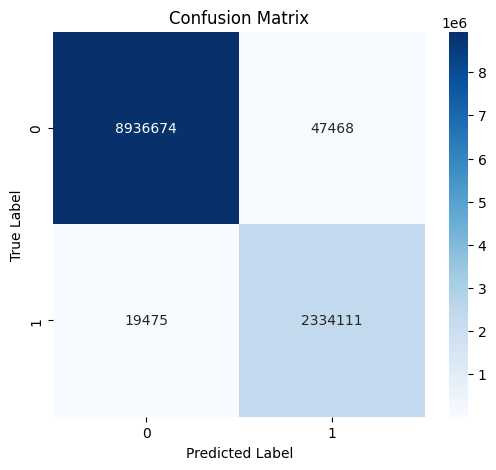

Accuracy : 0.9941
Precision: 0.9801
Recall   : 0.9917
F1-score : 0.9859
IoU      : 0.9721


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import seaborn as sns

threshold = 0.5
pred_test = model1.predict(X_test1)
pred_test = (pred_test > threshold).astype(np.uint8)


# === 1. Flatten array (ubah dari 4D menjadi 1D untuk evaluasi) ===
y_true_flat = y_test.flatten()
y_pred_flat = pred_test.flatten()

# === 2. Hitung confusion matrix ===
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)

# === 3. Visualisasi confusion matrix ===
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Simpan ke file PNG dengan resolusi tinggi
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# === 4. Hitung metrik evaluasi ===
accuracy  = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall    = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1        = f1_score(y_true_flat, y_pred_flat, zero_division=0)
iou       = jaccard_score(y_true_flat, y_pred_flat, zero_division=0)

# === 5. Tampilkan hasil ===
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"IoU      : {iou:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
(173, 256, 256, 1)


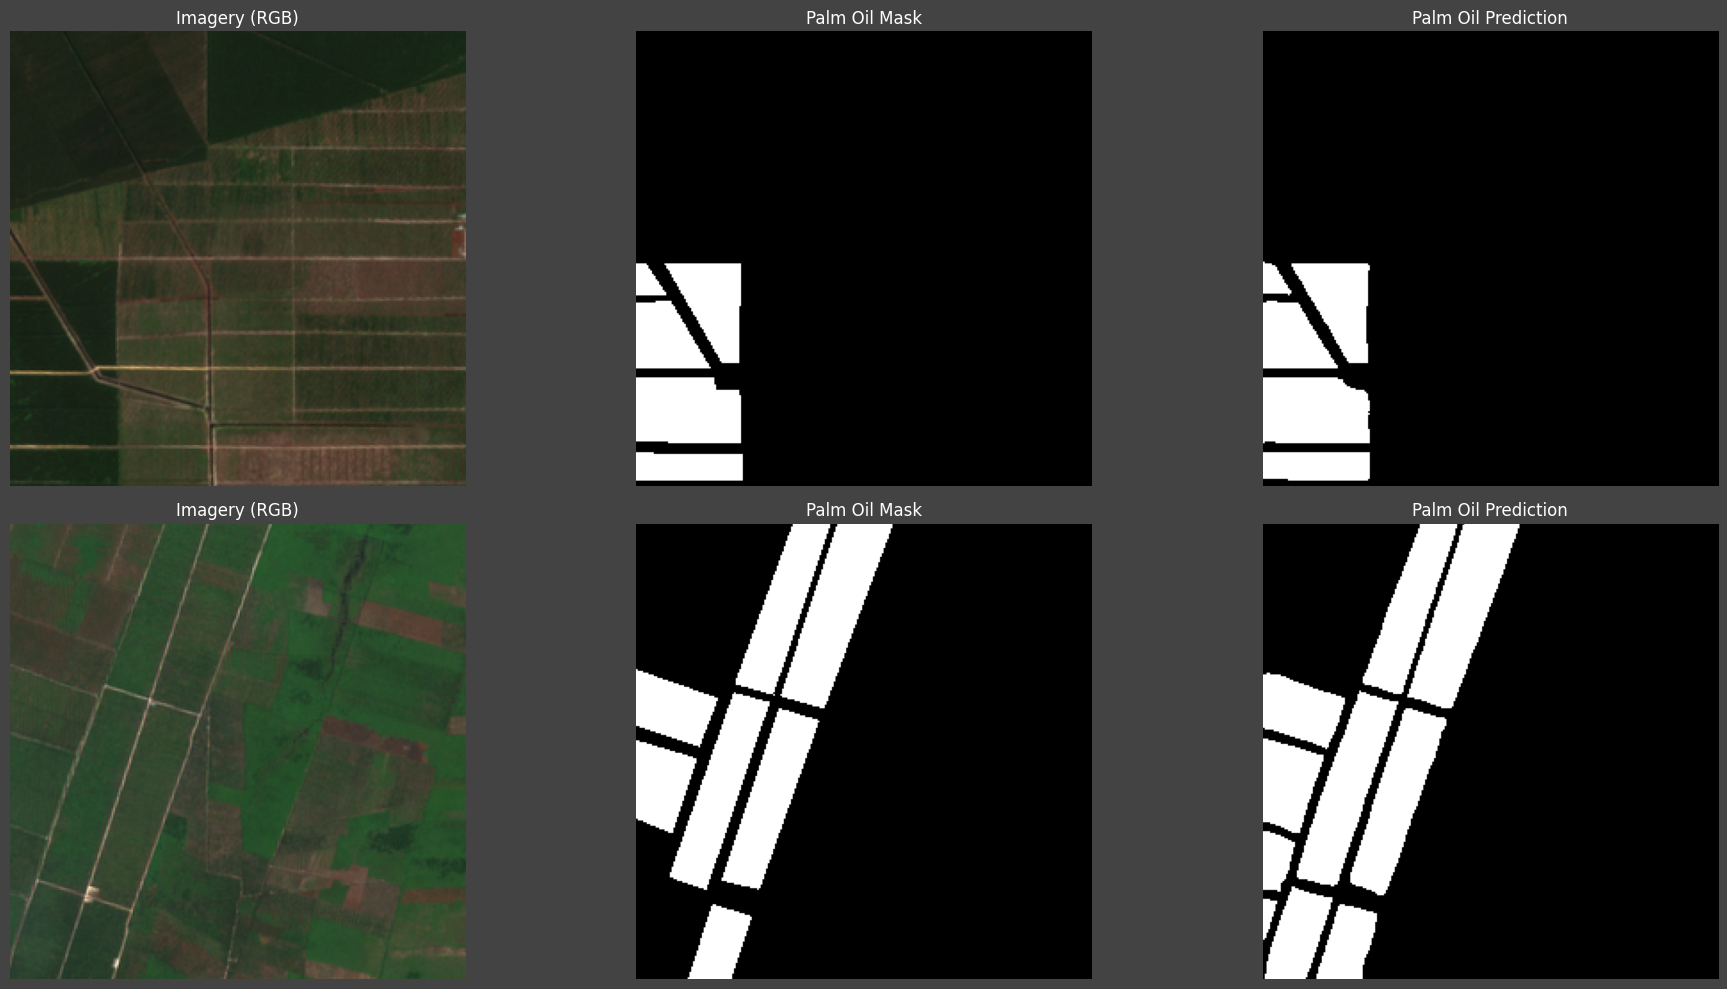

In [23]:
threshold = 0.5

# prediction of the output
pred_test = model1.predict(X_test1)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values 
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

BG = "#434343"  # pilih warna latar yang kamu mau


fig.patch.set_facecolor(BG)
for a in ax.ravel():
    a.set_facecolor(BG)

idx1 = 68
idx2 = 20

ax[0][0].imshow(X_test1[idx1])
ax[0][0].set_title("Imagery (RGB)", color="white")
ax[0][0].set_axis_off()

ax[0][1].imshow(y_test[idx1, :, :, 0], cmap="gray")
ax[0][1].set_title("Palm Oil Mask", color="white")
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_test[idx1, :, :, 0], cmap="gray")
ax[0][2].set_title("Palm Oil Prediction", color="white")
ax[0][2].set_axis_off()

# === Baris kedua ===
ax[1][0].imshow(X_test1[idx2])
ax[1][0].set_title("Imagery (RGB)", color="white")
ax[1][0].set_axis_off()

ax[1][1].imshow(y_test[idx2, :, :, 0], cmap="gray")
ax[1][1].set_title("Palm Oil Mask", color="white")
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_test[idx2, :, :, 0], cmap="gray")
ax[1][2].set_title("Palm Oil Prediction", color="white")
ax[1][2].set_axis_off()

plt.tight_layout()
plt.show()